# Analyze Distribution

Analyzes the distribution of loss values.

In [7]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

os.environ['JAX_PLATFORM_NAME'] = "cpu"
os.environ['JAX_PLATFORMS'] = "cpu"

In [8]:
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
import statsmodels.api as sm
import scipy.stats

from analyzers import database, defaultvalues as dv, loss as loss_analyzer

from simulation.simulate_full import run_entire_simulation
import jax

database.set_filename("../data/loss_analyzer/distribution_analysis.npz")

In [9]:
sim_keys = np.arange(1, 51, dtype=int).reshape(-1, 10)


def get_sim_result(key):
    return run_entire_simulation(3.0, dv.N_STEPS, dv.N_MOLECULES_PER_AXIS, dv.N_SNAPSHOTS, dv.N_Q, key)

In [10]:
for key_set in sim_keys:
    all_keys = database.get_existing_keys()
    if all([key in all_keys for key in key_set]):
        print(f"Skipping keys from {key_set[0]} to {key_set[-1]}, already computed")
        continue

    print(f"=== For keys from {key_set[0]} to {key_set[-1]} ===")
    patterns = jax.vmap(get_sim_result)(key_set)
    for key, value in zip(key_set, patterns):
        database.save_intermediate_result(key, value)


Skipping keys from 1 to 10, already computed
Skipping keys from 11 to 20, already computed
Skipping keys from 21 to 30, already computed
Skipping keys from 31 to 40, already computed
Skipping keys from 41 to 50, already computed


In [11]:
keys, patterns = database.load_result()

N_PATTERNS_TOTAL, N_QS = patterns.shape

losses = []
for i, fitted_x in enumerate(patterns):
    for j, fitted_y in enumerate(patterns):
        if i == j:
            continue
        losses.append(loss_analyzer.L1_loss(fitted_x, fitted_y))

losses = np.array(losses)
print(keys.shape)
print(losses.shape)

(50,)
(2450,)


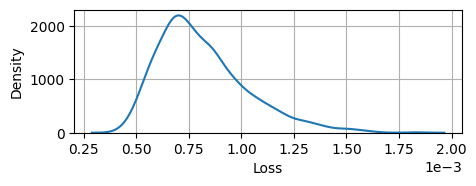

In [12]:
from matplotlib.ticker import FormatStrFormatter

sns.kdeplot(losses, bw_adjust=1)

plt.xlabel("Loss")
plt.ylabel("Density")
plt.grid()
plt.gcf().set_size_inches(5, 1.6)
#plt.gca().xaxis.set_major_formatter(FormatStrFormatter("%.4f"))
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.savefig("../plots/analysis_distribution.svg")
plt.show()

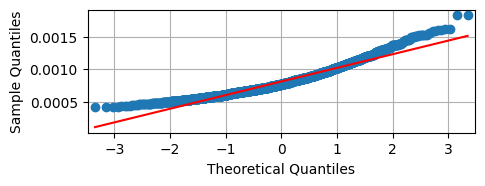

In [69]:
sm.qqplot(losses, line='r')
plt.grid()
plt.gcf().set_size_inches(5, 1.6)
plt.savefig("../plots/analysis_distribution_qq.svg")
plt.show()

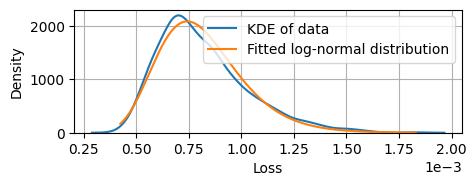

In [74]:
# Source: https://stackoverflow.com/a/48714620
fitting_params = scipy.stats.lognorm.fit(losses, floc=0)
norm_dist_fitted = scipy.stats.lognorm(*fitting_params)

fitted_x = np.linspace(min(losses), max(losses), 1000)
fitted_y = norm_dist_fitted.pdf(fitted_x)

sns.kdeplot(losses, bw_adjust=1, label="KDE of data")
plt.plot(fitted_x, fitted_y, label="Fitted log-normal distribution")

plt.xlabel("Loss")
plt.ylabel("Density")
plt.grid()
plt.gcf().set_size_inches(5, 1.6)
#plt.gca().xaxis.set_major_formatter(FormatStrFormatter("%.4f"))
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend()
plt.savefig("../plots/analysis_distribution.svg")
plt.show()

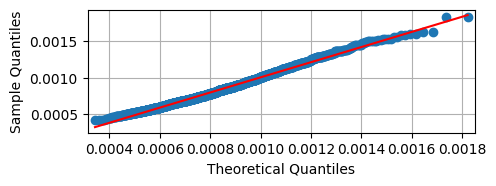

In [68]:
sm.qqplot(losses, dist=scipy.stats.lognorm(*fitting_params), line='r')
plt.grid()
plt.gcf().set_size_inches(5, 1.6)
plt.savefig("../plots/analysis_distribution_qq_lognormal.svg")
plt.show()